# APPUNTI
Il dataset è scaricabile da qui: https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv

Contiene le seguenti variabili:

- Frutto: Il tipo di frutto. **Questa è la variabile di destinazione (target) che vogliamo prevedere**.
- Peso (g): Il peso del frutto in grammi. Variabile continua.
- Diametro medio (mm): Il diametro medio del frutto in millimetri. Variabile continua.
- Lunghezza media (mm): La lunghezza media del frutto in millimetri. Variabile continua.
- Durezza buccia (1-10): La durezza della buccia del frutto su una scala da 1 a 10. Variabile continua.
- Dolcezza (1-10): La dolcezza del frutto su una scala da 1 a 10. Variabile continua.

# 1. Importo Librerie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 2. Definizione Costanti

In [2]:
RANDOM_SEED = 0
BASE_URL = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/'

# 3. Funzioni Utili

In [3]:
# Funzione per stampare il Classification_report con tutte le metriche necessarie per valutare il modello:
def print_classification_report(model, data):
  X, y = data
  y_pred = model.predict(X)
  print(classification_report(y, y_pred))
  print(confusion_matrix(y, y_pred))

# 4. Importo Dataset + Preprocessing (EDA)

In [4]:
df = pd.read_csv(BASE_URL + 'fruits.csv')
df.head()

,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,Mela,86.40,89.68,8.69,9.61,2.41
1,Mela,77.58,73.45,6.49,7.20,3.87
2,Mela,81.95,81.66,6.40,9.09,2.88
3,Mela,66.33,36.71,6.78,8.21,2.55
4,Mela,56.73,75.69,5.78,9.15,3.88


In [5]:
df.count() # 500 esempi da usare per addestrare il nostro modello

,0
Frutto,500
Peso (g),500
Diametro medio (mm),500
Lunghezza media (mm),500
Durezza buccia (1-10),500
Dolcezza (1-10),500


In [6]:
# Check che i valori siano sulla stessa scala:
print(df.describe(include='all'))

       Frutto    Peso (g)  Diametro medio (mm)  Lunghezza media (mm)  \
count     500  500.000000           500.000000            500.000000   
unique      5         NaN                  NaN                   NaN   
top      Mela         NaN                  NaN                   NaN   
freq      100         NaN                  NaN                   NaN   
mean      NaN   47.313440            86.573100              5.298620   
std       NaN   26.768797            64.293403              2.641993   
min       NaN    8.570000             7.530000              1.150000   
25%       NaN   24.797500            50.510000              2.672500   
50%       NaN   42.380000            70.450000              5.670000   
75%       NaN   68.080000            88.852500              7.455000   
max       NaN  111.210000           299.890000             11.140000   

        Durezza buccia (1-10)  Dolcezza (1-10)  
count              500.000000       500.000000  
unique                    NaN        

I valori sono su scale diverse (ad esempio, il peso ha un range tra 8.57 e 111, mentre la lunghezza media solo tra 1.15 e 11.14), pertanto vanno sicuramente standardizzati. Ma andiamo prima di tutto a codificare la variabile target:

In [7]:
# Check valori mancanti:
df.isna().sum()

,0
Frutto,0
Peso (g),0
Diametro medio (mm),0
Lunghezza media (mm),0
Durezza buccia (1-10),0
Dolcezza (1-10),0


Non ci sono valori mancanti. Ottimo!

Vediamo altre cose che possiamo valutare tramite EDA prima di passare all'encoding del target.

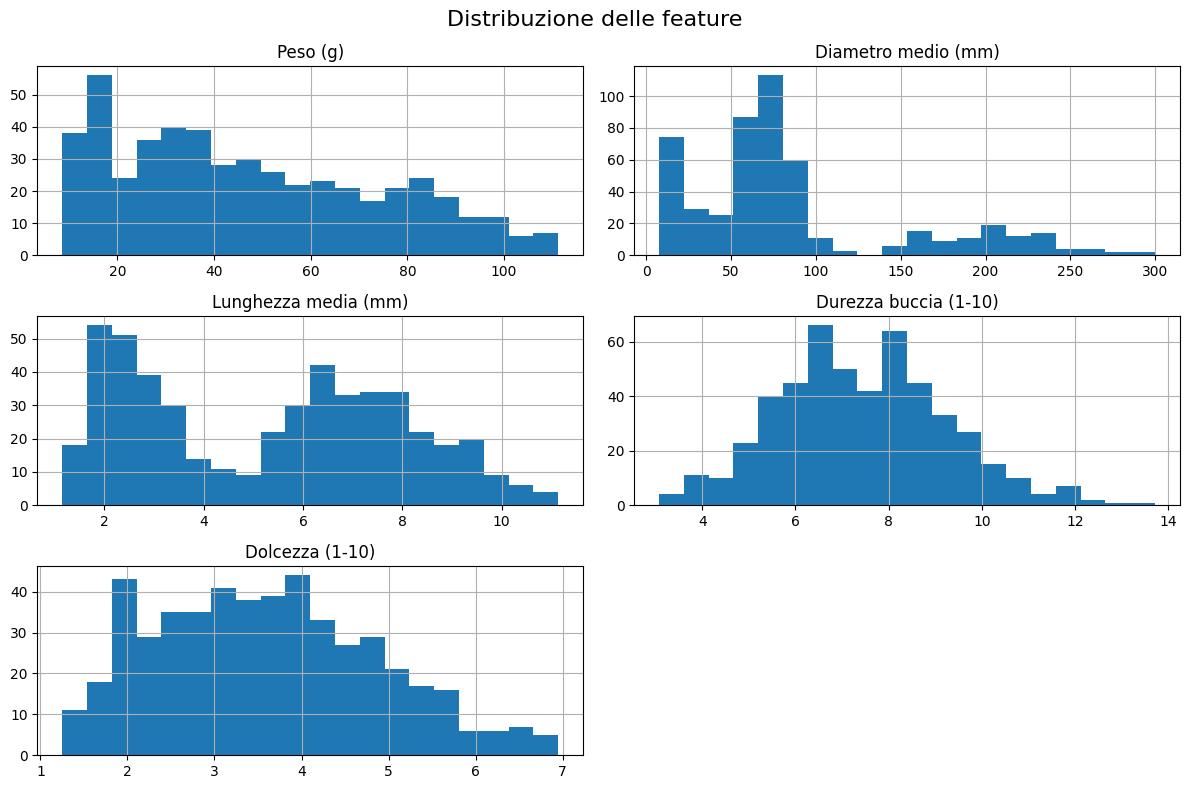

In [8]:
# 1. Distribuzioni (Istogramma + KDE):
df.drop("Frutto", axis=1).hist(bins=20, figsize=(12, 8))
plt.suptitle("Distribuzione delle feature", fontsize=16)
plt.tight_layout()
plt.show()

Ecco come possiamo interpretare i dati:
- PESO: distribuzione asimmetrica verso destra => la maggior parte dei frutti pesa poco (tra i 10 e 50 g), ma ci sono anche frutti più pesanti. Inoltre, la coda lunga verso destra indica che alcuni frutti hanno un peso significativamente maggiore (=> presenza di outlier). QUINDI, QUESTA FEATURE CI HA GIÀ DISCRIMINATO I FRUTTI PICCOLI (come l'uva che, ovviamente, pesa meno rispetto ad una mela) DA QUELLI GRANDI (come arance o mele).

- DIAMETRO MEDIO (mm): Qui possiamo innanzitutto notare come abbiamo una **DISTRIBUZIONE MUTIMODALE** (*più picchi* -> ci sono gruppi di frutti con diametri ben distinti (ex. uva molto piccola, mela media, ecc.)). => Pertanto, ricaviamo facilmente che **questa è una feature molto informativa per distinguere le classi**.


- LUNGHEZZA MEDIA (mm): anche in questo caso ci sono più picchi -> anche in questo caso si tratta dunque di una distribuzione multimodale => anche questa è una **buona feature discriminativa**.

- DUREZZA BUCCIA (1-10): qui notiamo invece una distribuzione gaussiana (e lo noti perché i picchi sono centrati molto vicini, tra 8 e 8). Inoltre, ci sono degli OUTLIER nei valori estremi sopra 12.... ma il range era tra 1 e 10! Pertanto, è possibile che ci siano errori o valori anomali =====> **potrebbe essere utile confrontarla con il target tramite boxplot**.

- DOLCEZZA (1-10): in questo caso l'asimmetria della distribuzione è presente a sinistra => infatti, tra 1.5 e 4.5 ci sono molti frutti poco dolci, ma poi il trend scende tra 4.5 e 7, con pochi frutti molto dolci. Inoltre, anche qui sono presenti outlier oltre 6.5.


Dunque, dobbiamo verificare l'effettiva presenza di outlier per DUREZZA e DOLCEZZA.

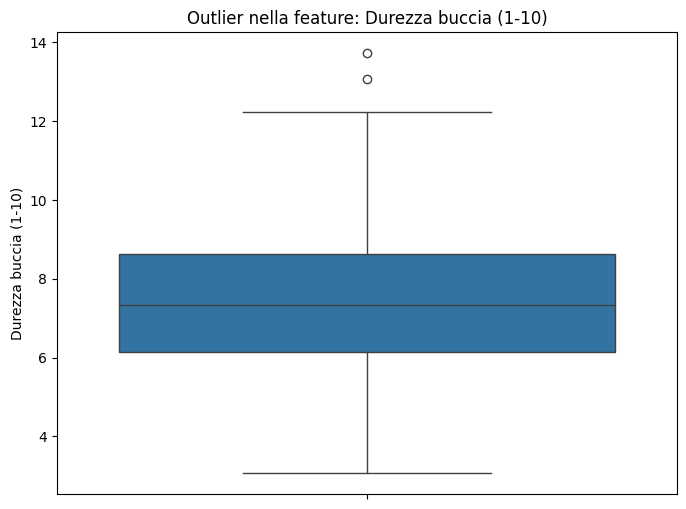

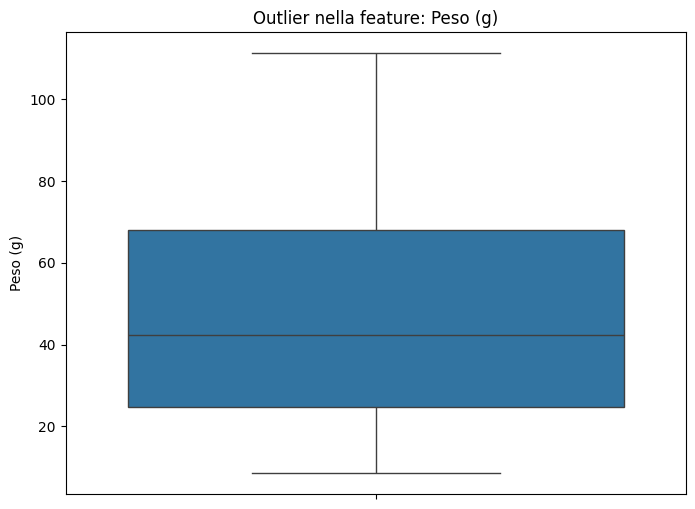

In [10]:
import seaborn as sns
# Verifico outlier per le 2 feature "DOLCEZZA" e "DUREZZA":
colonne = ["Durezza buccia (1-10)", "Peso (g)"]
for col in colonne:
  plt.figure(figsize=(8, 6))
  sns.boxplot(df[col])
  plt.title(f"Outlier nella feature: {col}")
  plt.show()

Notiamo che "Durezza buccia" ha effettivamente 2 outlier, mentre Dolcezza (1-10) non ha outlier.
Per curiosità, verifico anche il Peso.... no, neanche il Peso.

E ora? Semplicemente, essendo i valori di Durezza buccia tra 1 e 10 come valori possibili, possiamo andare a rimuovere gli outlier.

### Matrice di Correlazione

Controlliamo anche la correlazione tra le feature e il target:

In [21]:
df.corr()

,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
Frutto,1.000000,-0.470219,-0.411351,0.179510,0.090770,0.448203
Peso (g),-0.470219,1.000000,-0.085113,0.583687,-0.485335,0.163286
Diametro medio (mm),-0.411351,-0.085113,1.000000,-0.166470,0.034933,-0.569352
Lunghezza media (mm),0.179510,0.583687,-0.166470,1.000000,-0.499412,0.329534
Durezza buccia (1-10),0.090770,-0.485335,0.034933,-0.499412,1.000000,-0.223080
Dolcezza (1-10),0.448203,0.163286,-0.569352,0.329534,-0.223080,1.000000


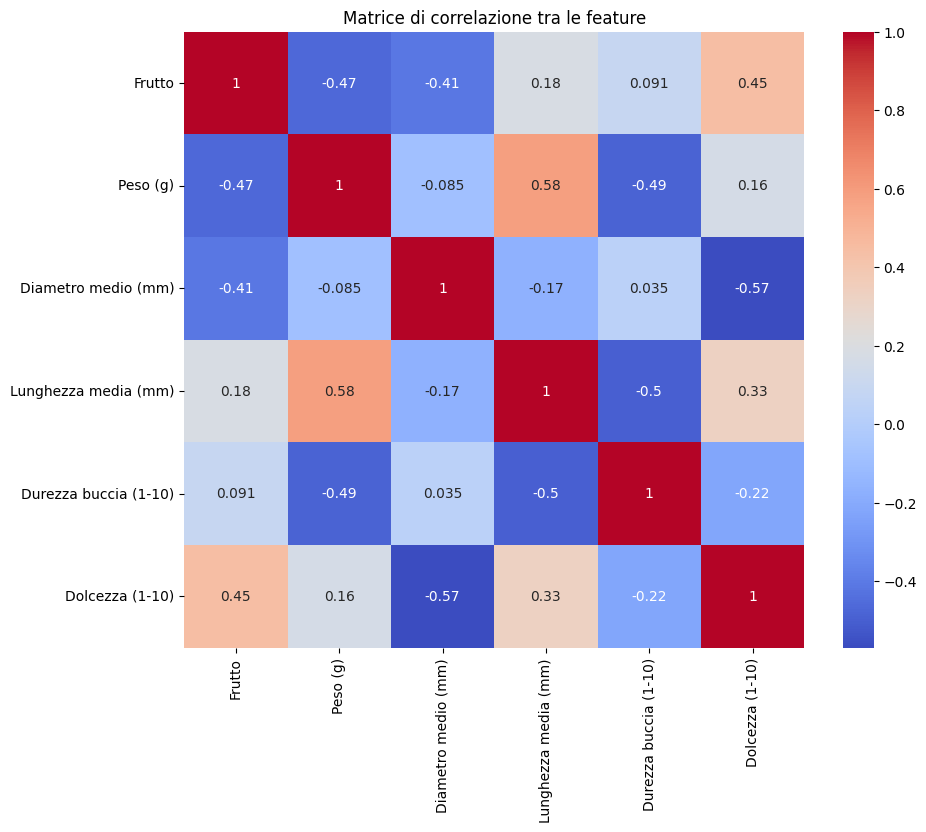

In [22]:
# Vediamola graficamente:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice di correlazione tra le feature")
plt.show()

Possiamo notare che le variabili maggiormente correlate col target sono:
- Peso (g) -> -0.47: negativamente correlate.
- Dolcezza (1-10) -> 0.45: positivamente correlate (e se ci pensi ha senso, in quanto perché dalla dolcezza si potrebbe intuire che tipo di frutto è).

Non male anche il Diametro Medio.

A questo punto, poiché il nostro obiettivo è costruire un modello predittivo, allora:
- potrei selezionare le feature più correlate al target per costruire modelli più semplici e performanti.
- L’idea è che le feature fortemente correlate con il target contengano più informazione utile.

Per ora, però, addestriamo il modello sfruttando tutte le feature.

In [20]:
X[:,3] > 12

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [12]:
# Label Encoding sulla colonna target "Frutto":
class_encoding = {"Mela": 0, "Banana": 1, "Arancia": 2, "Uva": 3, "Kiwi": 4}
df["Frutto"] = df["Frutto"].map(lambda x: class_encoding[x])
df.head()

,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,0,86.40,89.68,8.69,9.61,2.41
1,0,77.58,73.45,6.49,7.20,3.87
2,0,81.95,81.66,6.40,9.09,2.88
3,0,66.33,36.71,6.78,8.21,2.55
4,0,56.73,75.69,5.78,9.15,3.88


In [13]:
# Ricaviamo X e y:
X = df.drop("Frutto", axis=1).values
y = df["Frutto"].values

X.shape, y.shape

((500, 5), (500,))

In [14]:
# Infine, ricaviamo train set e test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train.shape # 400 esempi da usare per il set di addestramento

(400, 5)

# 5. Standardizzazione

In [15]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# 6. Addestramento

Secondo il KNN, devo innanzitutto scegliere un valore di K osservazioni e calcolare la distanza del punto da classificare da tali osservazioni.

Dopodiché, viene assegnata la classe più presente tra i k neighbors al punto che sto classificando.

Testo dunque per vari valori di K, valuto l'Accuracy e poi scelgo il modello con il valore di K migliore (=> Il modello migliore è quello che non ha una grande differenza tra train set e test set in termini di accuracy, e che ovviamente non è né in overfitting né in underfitting).

In [16]:
Ks = [1, 2, 3, 4, 5, 10, 12, 15, 20, 30, 40, 50]

for k in Ks:
  print(f"K = {k}")

  # Creazione modelli + fit + calcolo previsioni (anche prob. essendo un problema di classificazione):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)

  y_pred_train = knn.predict(X_train)
  y_proba_train = knn.predict_proba(X_train)

  y_pred_test = knn.predict(X_test)
  y_proba_test = knn.predict_proba(X_test)

  # Valutiamo accuracy:
  acc_train = accuracy_score(y_train, y_pred_train)
  acc_test = accuracy_score(y_test, y_pred_test)

  # Stampiamo:
  print(f"ACCURACY: TRAIN={acc_train:.3f}, TEST={acc_test:.3f}")

K = 1
ACCURACY: TRAIN=1.000, TEST=0.910
K = 2
ACCURACY: TRAIN=0.970, TEST=0.880
K = 3
ACCURACY: TRAIN=0.955, TEST=0.900
K = 4
ACCURACY: TRAIN=0.945, TEST=0.870
K = 5
ACCURACY: TRAIN=0.938, TEST=0.880
K = 10
ACCURACY: TRAIN=0.938, TEST=0.900
K = 12
ACCURACY: TRAIN=0.938, TEST=0.900
K = 15
ACCURACY: TRAIN=0.940, TEST=0.920
K = 20
ACCURACY: TRAIN=0.935, TEST=0.920
K = 30
ACCURACY: TRAIN=0.938, TEST=0.940
K = 40
ACCURACY: TRAIN=0.927, TEST=0.950
K = 50
ACCURACY: TRAIN=0.925, TEST=0.930


Notiamo che il modello migliore è per K = 40, dove abbiamo un'accuracy sul train set di 0.927 (non c'è un overfitting marcato), e l'accuracy sul test set è quella più alta ottenuta.

In [17]:
# Riaddestro dunque il modello per K = 40:
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=40)

In [18]:
# Stampo il report:
print_classification_report(knn, (X_test, y_test))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       1.00      1.00      1.00        19
           2       0.95      0.86      0.90        21
           3       1.00      1.00      1.00        25
           4       0.89      0.94      0.92        18

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

[[16  0  0  0  1]
 [ 0 19  0  0  0]
 [ 2  0 18  0  1]
 [ 0  0  0 25  0]
 [ 0  0  1  0 17]]


Analisi risultati:
- Precision: compresa tra lo 0.89 e 1 -> il modello commette pochi falsi positivi.
- Recall: compresa tra 0.94 (per la mela) e 1 (per banana e uva)  -> il modello riconosce correttamente quasi tutti i veri esempi.
- Accuracy: 0.95 -> il modello generalizza abbastanza bene (95% delle oss. classificate correttamente), e nessun overfitting evidente.

Si potrebbe provare a riaddestrare il modello con altri algoritmi come SVM, e confrontare le performance per vedere quale modello è il migliore.

Per quanto riguarda la confusion_matrix (analizzo giusto la prima riga):
- su 17 mele reali, 16 sono state classificate correttamente come mele.
- Nessuna mela è stata classificata come banana, arancia o uva, e solo 1 mela è stata scambiata per kiwi.
- Dunque, pochi falsi positivi.

Ecc.

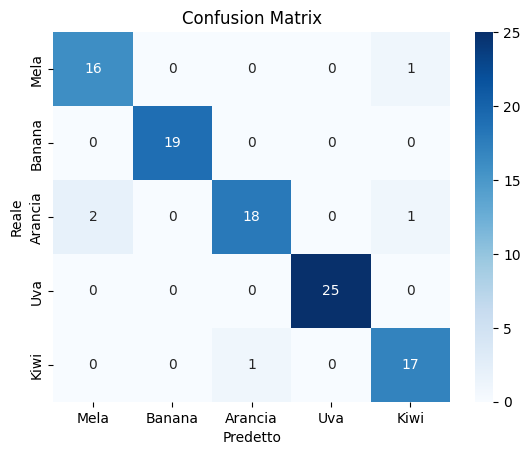

In [19]:
# Provo anche a disegnare il grafico della confusion_matrix tramite seaborn:
import seaborn as sns
y_pred_test = knn.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues',
             xticklabels=class_encoding.keys(),
            yticklabels=class_encoding.keys())
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Confusion Matrix")
plt.show()


TO DO PER MIGLIORARE LA QUALITÀ DELLA SOLUZIONE:
- Creare diversi modelli e confrontare le prestazioni, in modo da selezionare il modello migliore.

- Validazione incrociata (cross-validation): La scelta del miglior K sarebbe più robusta con K-Fold CV.

- Metriche aggiuntive: considerare macro/micro average (in caso di squilibri di classi), ROC/AUC se ha senso, oppure il Cohen’s Kappa per avere una misura della bontà rispetto al caso random.